In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)
# colors = ["#95D3A2", "#FFFFBF", "#F79051", ]
colors = ["#5657A4", "#95D3A2", "#FFFFBF", "#F79051", "#A30644"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

SAVE_PATH = r"E:\MS_ExperimentData\general"
# SAVE_PATH = r"D:\MS_ExperimentData\general"

In [13]:
k23 = 0.4
model = ChemotacticLotkaVolterra(
    k1=0.19, k2=k23, k3=k23, k4=0.28,
    boundaryLength=20, speedV=0.1, 
    diameter=0.3, repelPower=1,
    cellNumInLine=200, agentsNum=1000,
    chemoAlpha1=-10, chemoAlpha2=-10,
    diffusionRateD1=0.01, diffusionRateD2=0.01,
    dt=0.1, shotsnaps=15,
    tqdm=True, savePath=SAVE_PATH, overWrite=True
)
# model = ChemotacticLotkaVolterra(
#     k1=0.0, k2=0., k3=0., k4=0.,
#     boundaryLength=10, speedV=0.1, 
#     diameter=0.4, repelPower=1,
#     cellNumInLine=100, agentsNum=200,
#     chemoAlpha1=10, chemoAlpha2=-10,
#     diffusionRateD1=0.0, diffusionRateD2=0.0,
#     dt=0.1, shotsnaps=5,
#     tqdm=True, savePath=SAVE_PATH, overWrite=True
# )
# model.c1 = np.load("c1.npy")
# model.c2 = np.load("c1.npy")

In [14]:
model.run(8000)

  0%|          | 0/8000 [00:00<?, ?it/s]

200: 7m 37.3s

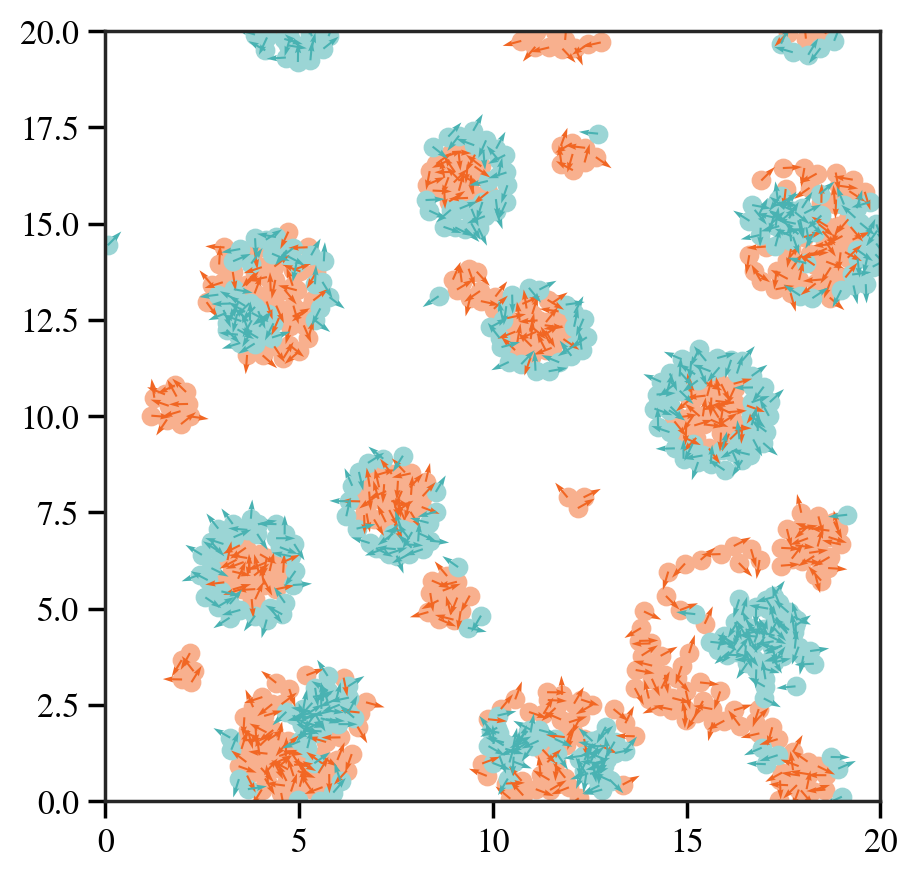

In [15]:
# model.update()
model.plot()

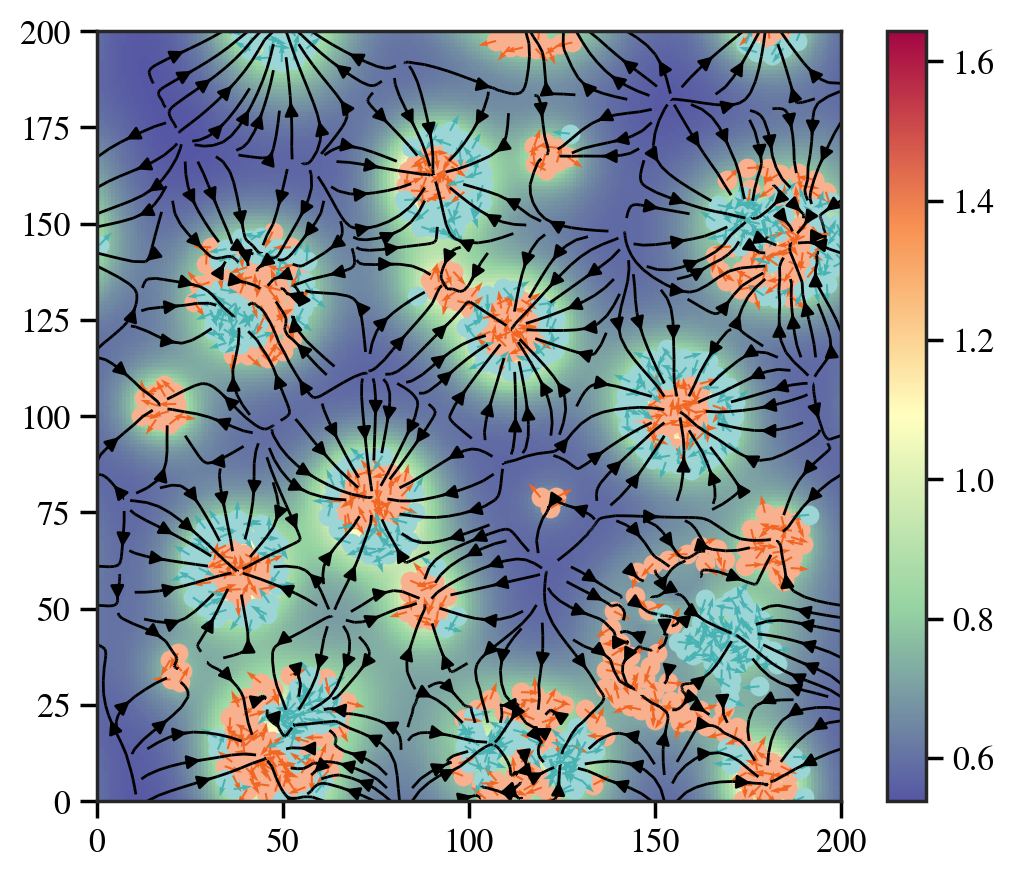

In [16]:
adjMulti = model.cellNumInLine / model.boundaryLength
cPosition = model.cPosition.reshape(model.cellNumInLine, model.cellNumInLine, 2)
X = cPosition[:, :, 0].T * adjMulti
Y = cPosition[:, :, 1].T * adjMulti
c = model.c1.copy().T
U = np.roll(c, -1, axis=1) - np.roll(c, 1, axis=1)
V = np.roll(c, -1, axis=0) - np.roll(c, 1, axis=0)
plt.streamplot(X, Y, U, V, color="black", linewidth=1, density=2)

plt.pcolor(model.c1.T, cmap=cmap)
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)

self = model

plt.scatter(
    self.positionX[:self.agentsNum // 2, 0] * adjMulti, self.positionX[:self.agentsNum // 2, 1] * adjMulti,
    color="#F8B08E", s=100 * self.diameter / 0.1 * (2.5 / self.boundaryLength) # edgecolors="black"
)
plt.scatter(
    self.positionX[self.agentsNum // 2:, 0] * adjMulti, self.positionX[self.agentsNum // 2:, 1] * adjMulti,
    color="#9BD5D5", s=100 * self.diameter / 0.1 * (2.5 / self.boundaryLength)  # edgecolors="black"
)
plt.quiver(
    self.positionX[:self.agentsNum // 2, 0] * adjMulti, self.positionX[:self.agentsNum // 2, 1] * adjMulti,
    np.cos(self.phaseTheta[:self.agentsNum // 2]), np.sin(self.phaseTheta[:self.agentsNum // 2]), color="#F16623"
)
plt.quiver(
    self.positionX[self.agentsNum // 2:, 0] * adjMulti, self.positionX[self.agentsNum // 2:, 1] * adjMulti,
    np.cos(self.phaseTheta[self.agentsNum // 2:]), np.sin(self.phaseTheta[self.agentsNum // 2:]), color="#49B2B2"
)

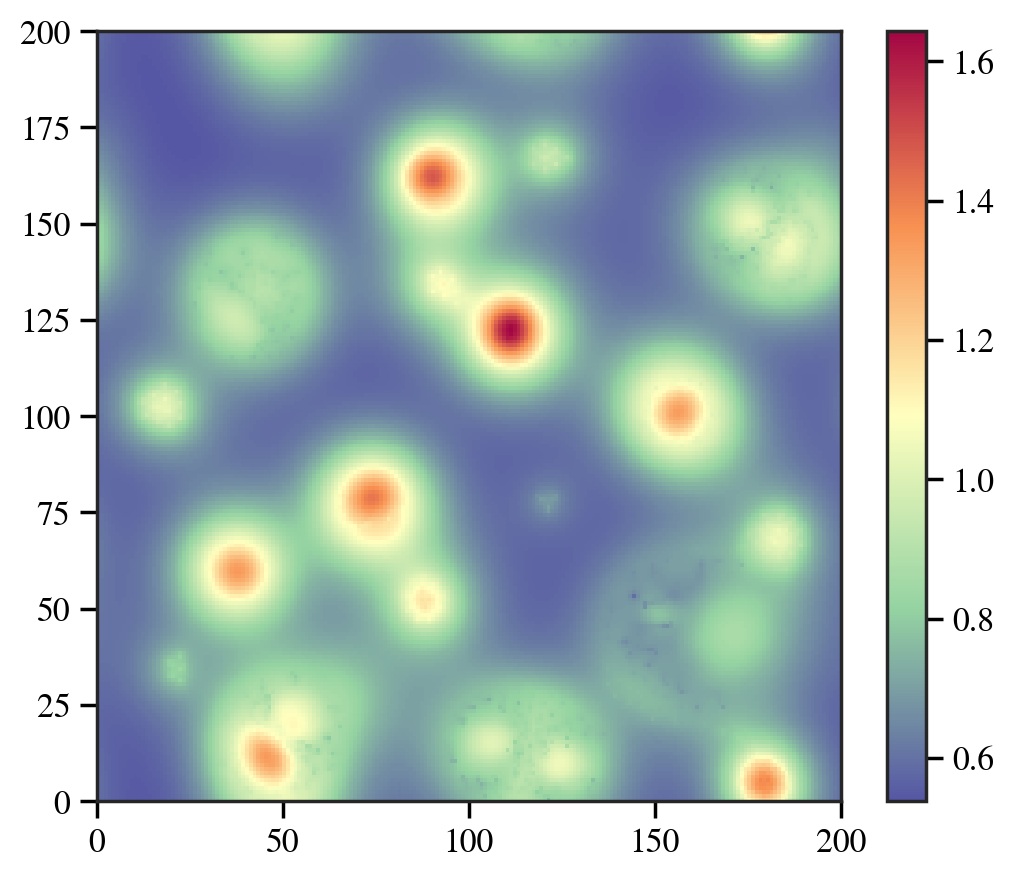

(0.0, 200.0)

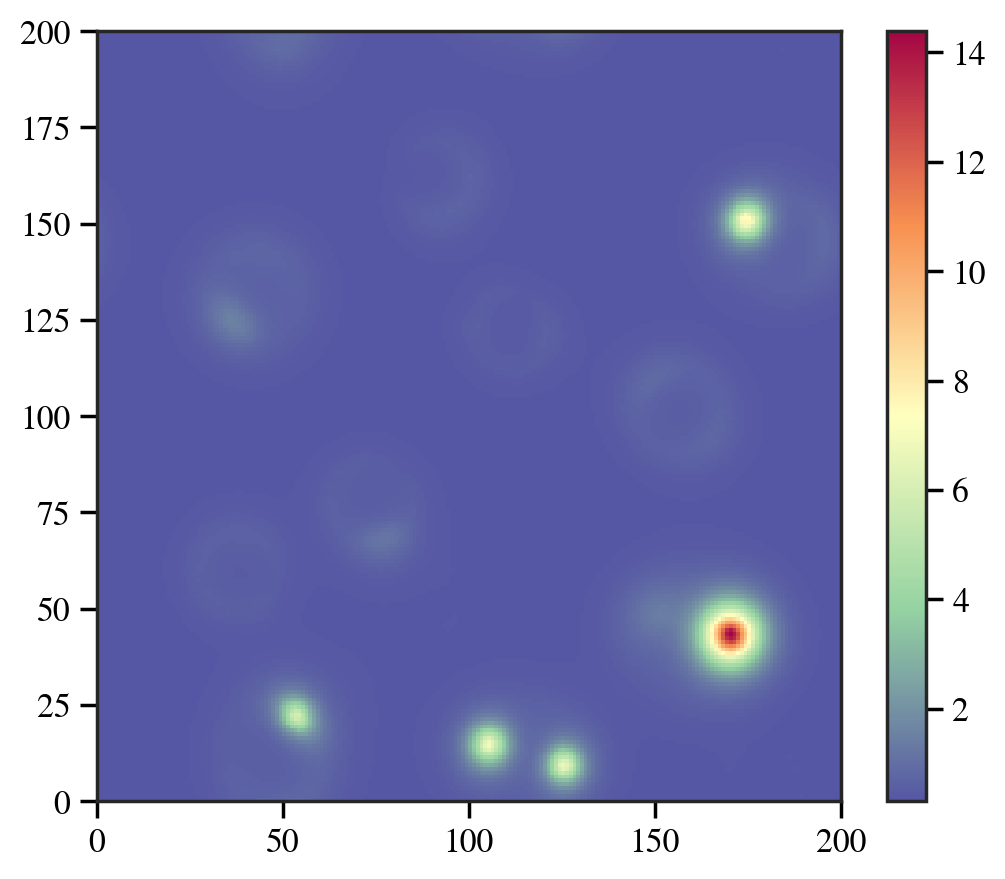

In [17]:
plt.pcolor(model.c1.T, cmap=cmap) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)
plt.show()
plt.pcolor(model.c2.T, cmap=cmap) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)

In [38]:
self = model

oscPosition = self.positionX[osci]
print(oscPosition)
osciIdx = self.temp["ocsiIdx"][osci]
print(osciIdx)
osciC1 = self.c1[osciIdx[0], osciIdx[1]]
print(osciC1)
osciC1Nabla = self.nablaC1[osciIdx[0], osciIdx[1]]
print(osciC1Nabla)
osciPhiC1 = np.arctan2(osciC1Nabla[1], osciC1Nabla[0])
print(np.cos(osciPhiC1), np.sin(osciPhiC1))
osciTheta = self.phaseTheta[osci]
print(np.cos(osciTheta), np.sin(osciTheta))

[9.57921034 6.96556133]
[96 68]
0.5802650954184903
[0.03026835 0.10270946]
0.28267933627268443 0.9592144665529365
-0.9612598069826392 0.27564394330312986


In [9]:
rightC1 = self.c1[(osciIdx[0] + 1) % self.cellNumInLine, osciIdx[1]]
leftC1 = self.c1[(osciIdx[0] - 1) % self.cellNumInLine, osciIdx[1]]
upperC1 = self.c1[osciIdx[0], (osciIdx[1] + 1) % self.cellNumInLine]
lowerC1 = self.c1[osciIdx[0], (osciIdx[1] - 1) % self.cellNumInLine]
np.array([leftC1 - rightC1, lowerC1 - upperC1]) / (2 * self.dx)

array([-0.01029192,  0.00017532])

In [3]:
a = np.array([
    ["左下", "左", "左上"],
    ["下", "中", "上"],
    ["右下", "右", "右上"]
])
print(a)
np.roll(a, -1, axis=1)[1, 1]
# a[1, 2]

[['左下' '左' '左上']
 ['下' '中' '上']
 ['右下' '右' '右上']]


'上'

In [11]:
rightC1, np.roll(self.c1, -1, axis=1)[osciIdx[0], osciIdx[1]]

(0.5964475037331732, 0.5963930000317788)

In [ ]:
# model = GSPatternFormation(strengthLambda=0.1, alpha=1.5, 
#                            boundaryLength=10, cellNumInLine=250, 
#                            productRateUK0=0, productRateVK0=0,
#                            diffusionRateDu=0.01, diffusionRateDv=0.001,
#                            decayRateKd=0, chemoBetaU=10,
#                            dt=0.02, shotsnaps=5,
#                            distribution="uniform", omegaMean=0.5, omegaStd=0,
#                            tqdm=True, overWrite=True, 
#                            savePath=SAVE_PATH)
beta = -5
model = GSPatternFormation(
    strengthLambda=0, alpha=1, 
    boundaryLength=10, cellNumInLine=250, 
    productRateUK0=1, productRateVK0=1,
    decayRateKd=0.001, speedV=0.5,
    chemoBetaU=beta, chemoBetaV=-beta,
    diffusionRateDu=0.01, diffusionRateDv=0.001,
    dt=0.02, shotsnaps=10000, typeA="heaviside",
    distribution="uniform", omegaMean=2, omegaStd=0,
    tqdm=True, savePath=SAVE_PATH, overWrite=True
)
self = model

(0.0, 10.0)

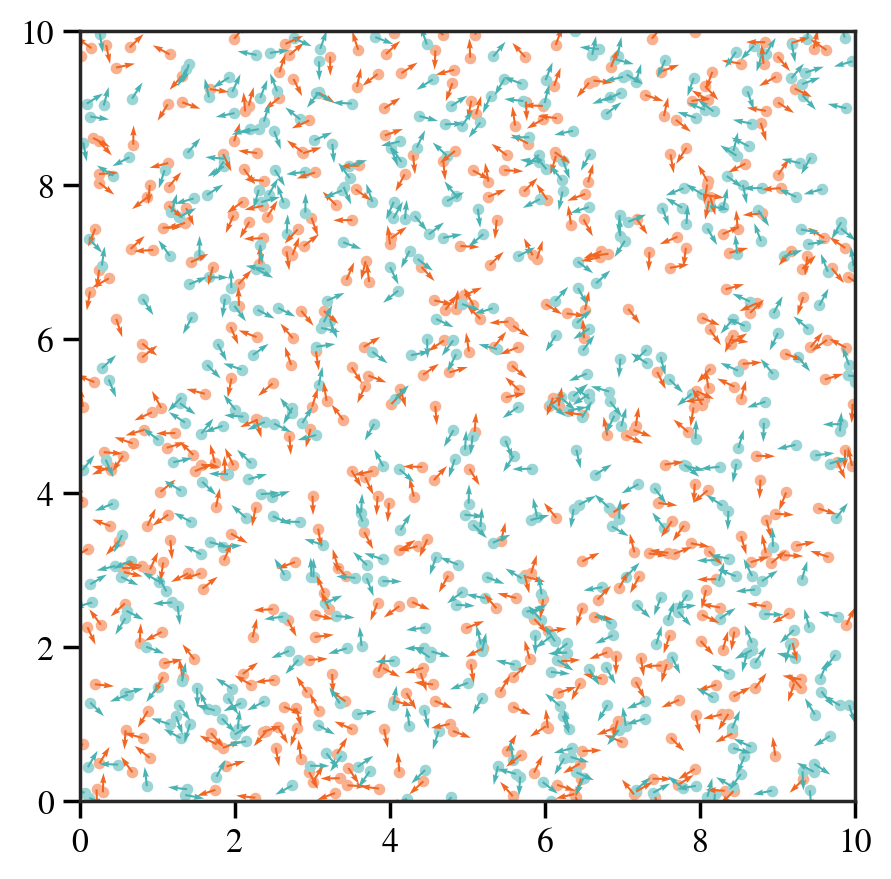

In [6]:
size = 10
self = model
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter(
    self.positionX[:self.agentsNum // 2, 0], self.positionX[:self.agentsNum // 2, 1],
    color="#F8B08E", s=size  # edgecolors="black"
)
ax.scatter(
    self.positionX[self.agentsNum // 2:, 0], self.positionX[self.agentsNum // 2:, 1],
    color="#9BD5D5", s=size  # edgecolors="black"
)
ax.quiver(
    self.positionX[:self.agentsNum // 2, 0], self.positionX[:self.agentsNum // 2, 1],
    np.cos(self.phaseTheta[:self.agentsNum // 2]), np.sin(self.phaseTheta[:self.agentsNum // 2]), color="#F16623"
)
ax.quiver(
    self.positionX[self.agentsNum // 2:, 0], self.positionX[self.agentsNum // 2:, 1],
    np.cos(self.phaseTheta[self.agentsNum // 2:]), np.sin(self.phaseTheta[self.agentsNum // 2:]), color="#49B2B2"
)
ax.set_xlim(0, self.boundaryLength)
ax.set_ylim(0, self.boundaryLength)


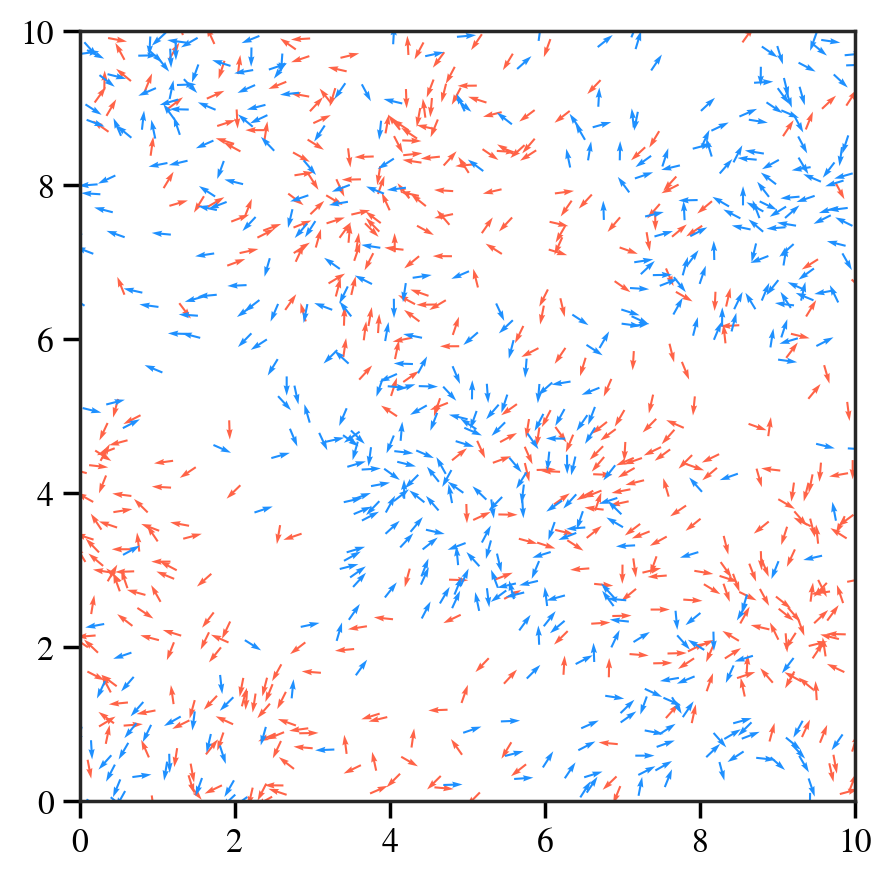

In [4]:
model.plot()

In [11]:
np.arange(0.1, 1.7, 0.3)

array([0.1, 0.4, 0.7, 1. , 1.3, 1.6])

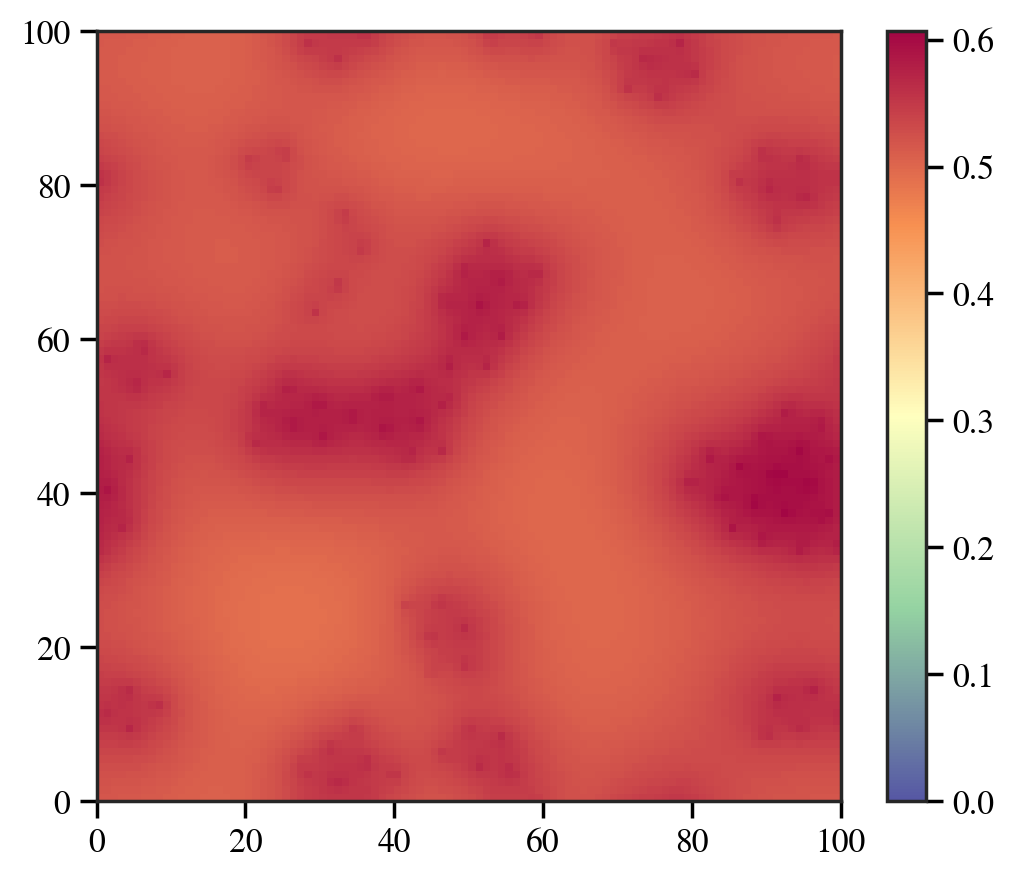

(0.0, 100.0)

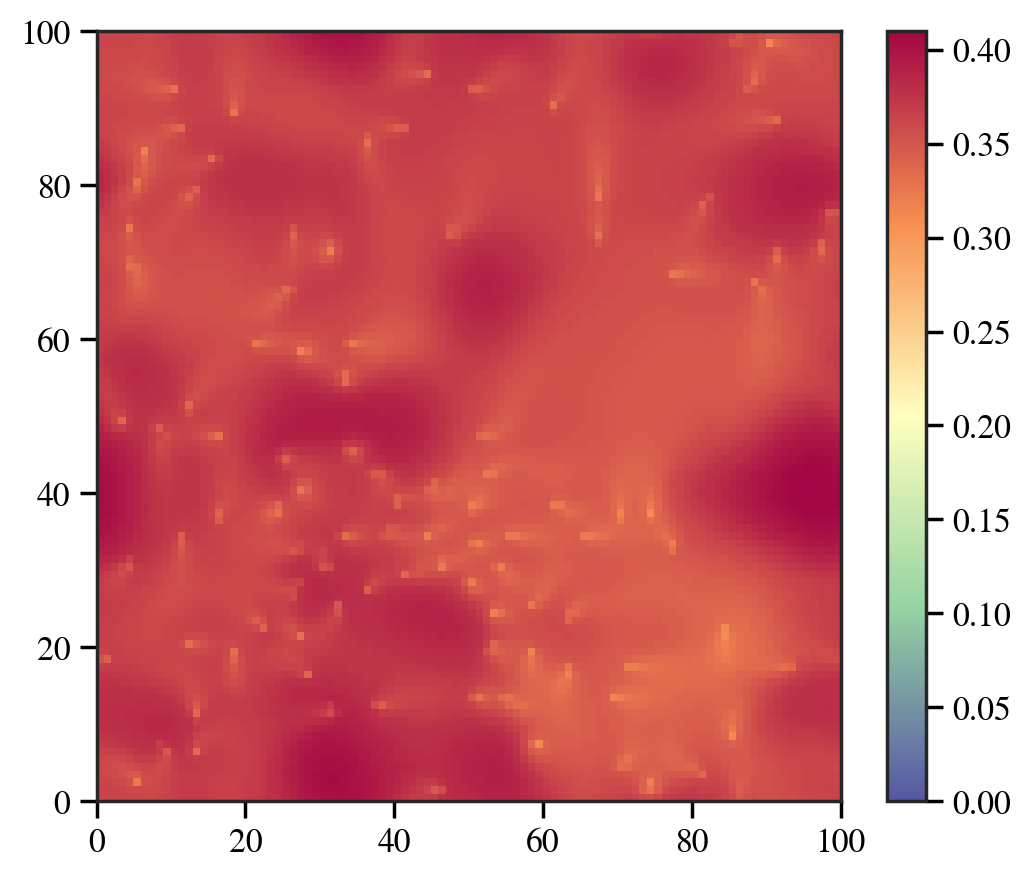

In [11]:
plt.pcolor(model.c1.T, cmap=cmap, vmin=0) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)
plt.show()
plt.pcolor(model.c2.T, cmap=cmap, vmin=0) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)

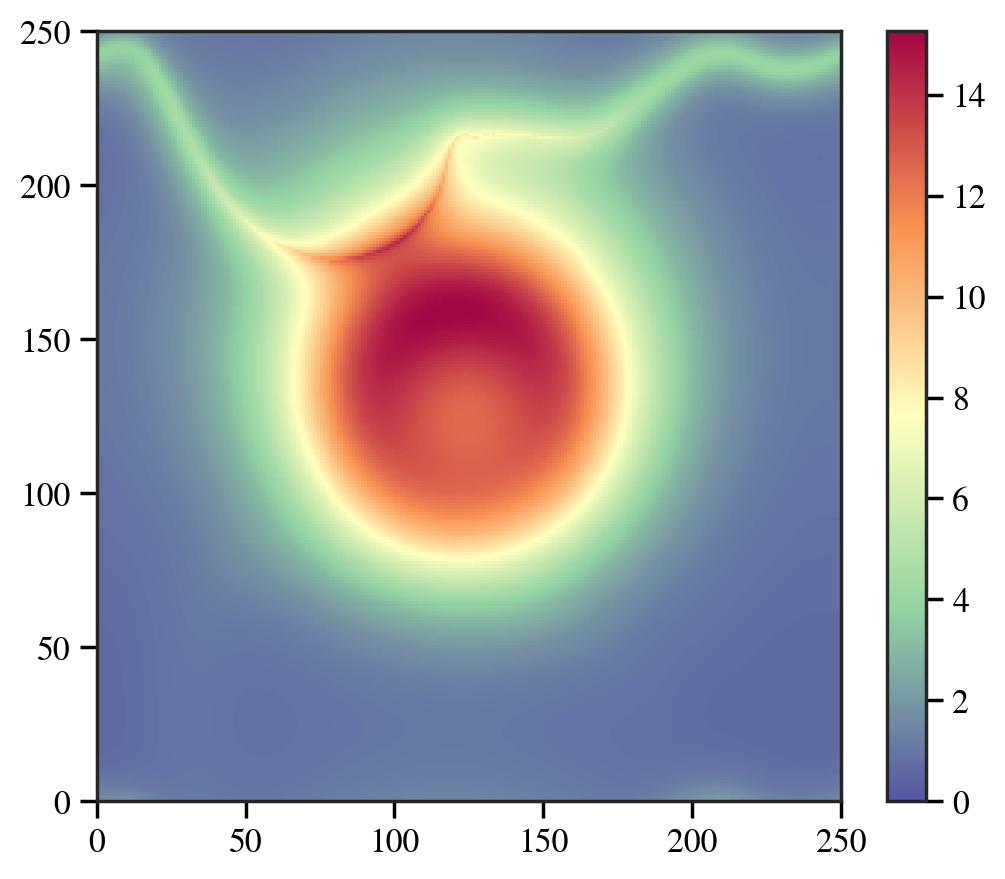

(0.0, 250.0)

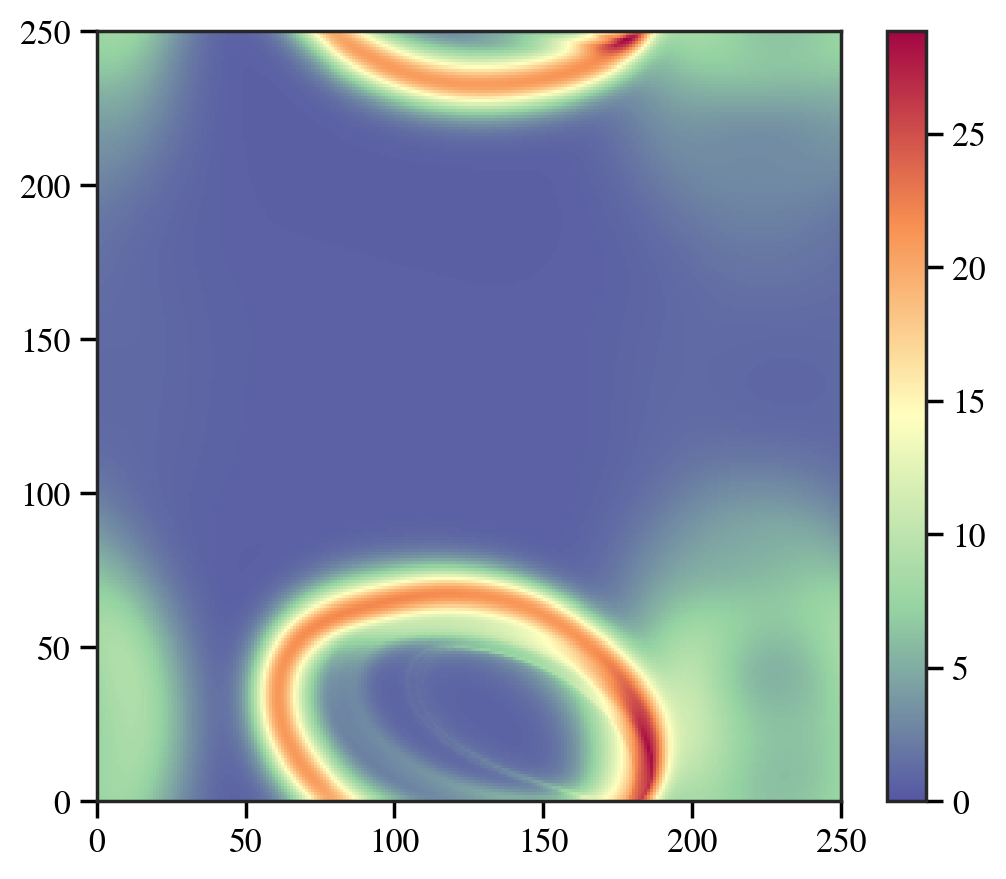

In [6]:
plt.pcolor(model.u.T, cmap=cmap, vmin=0) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)
plt.show()
plt.pcolor(model.v.T, cmap=cmap, vmin=0) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)

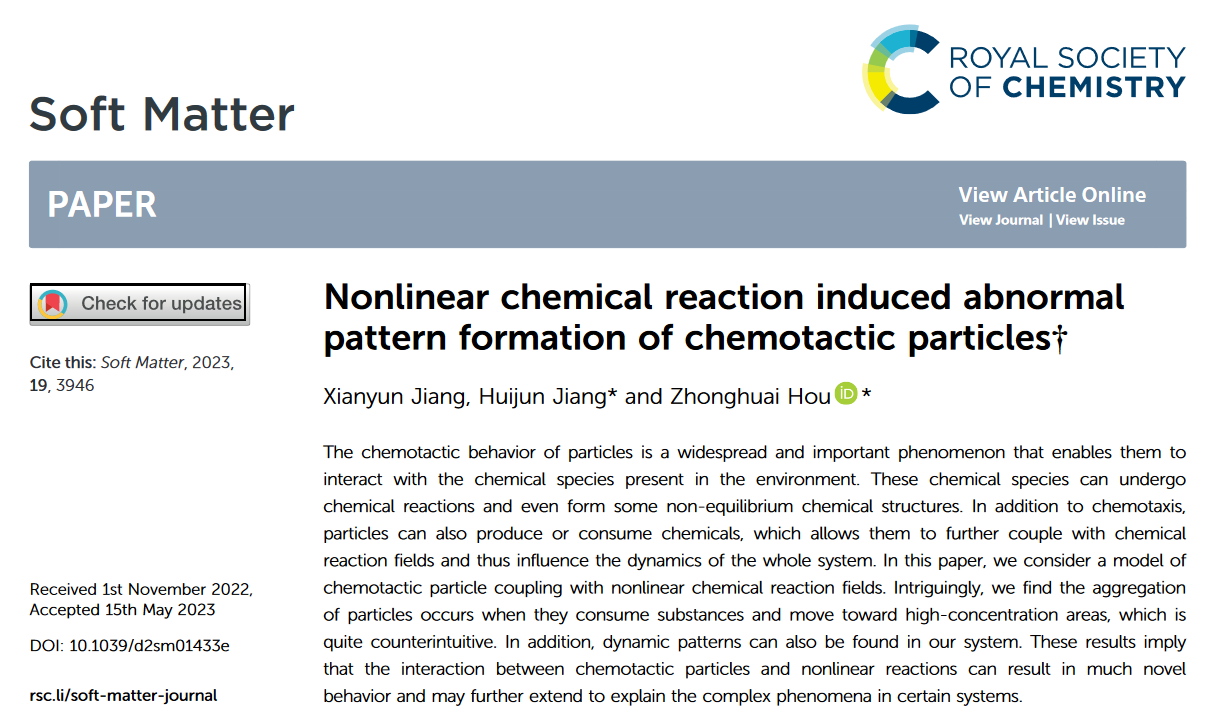
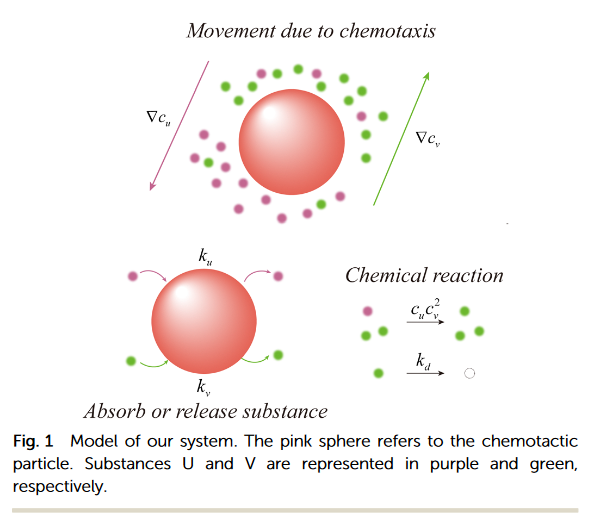
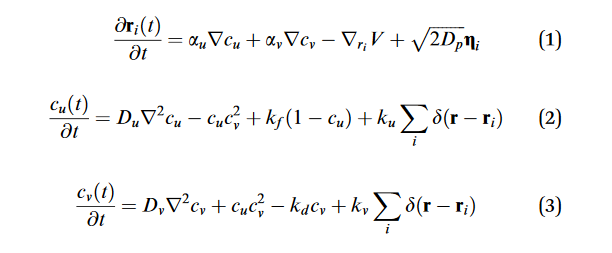

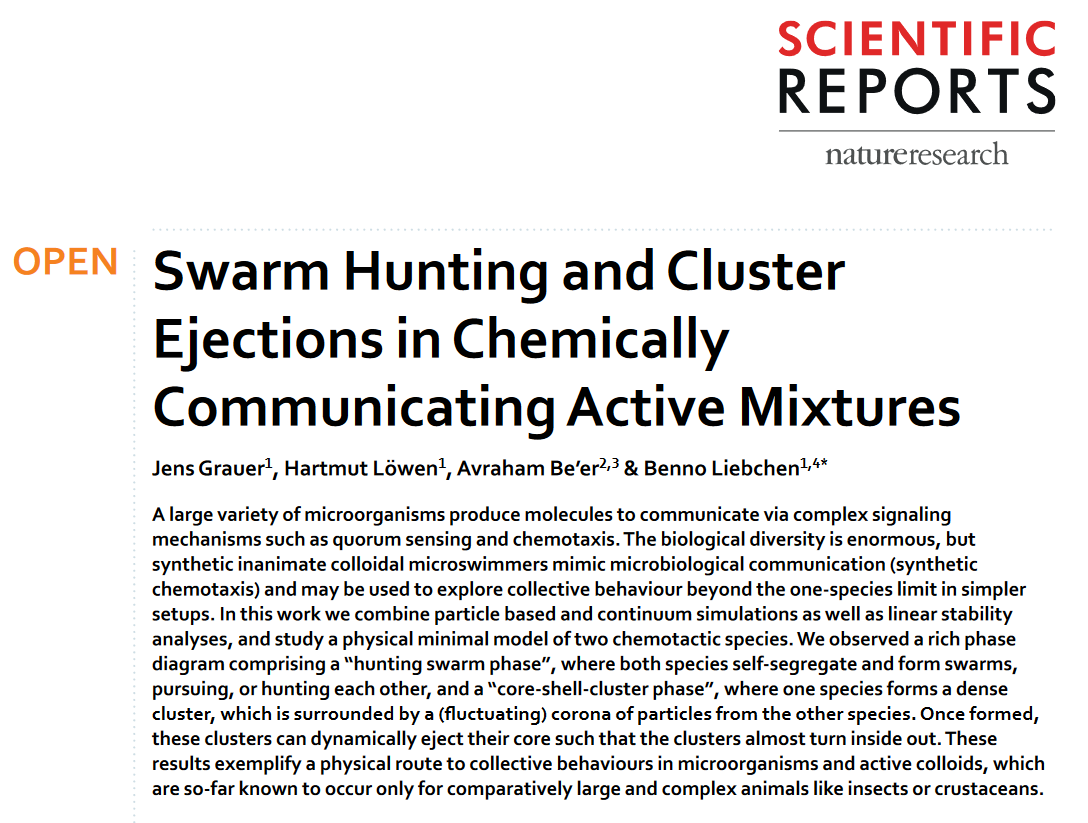
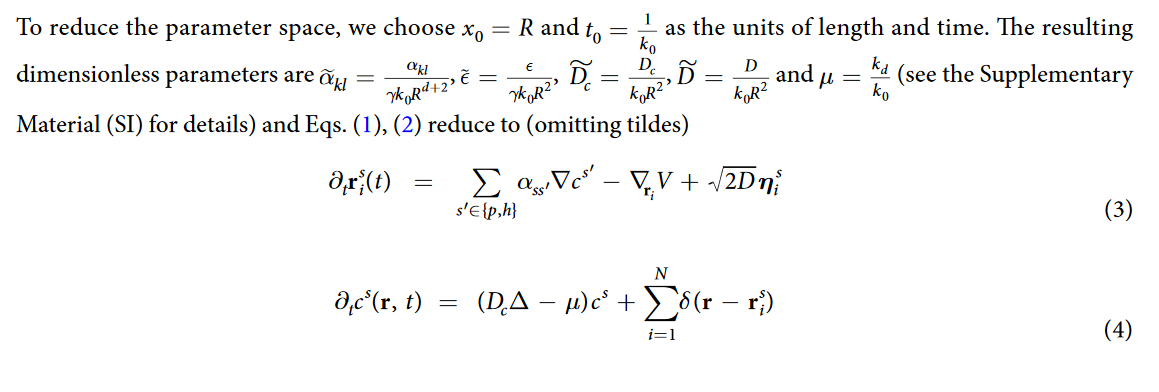

shot 10 2m31s

In [ ]:
alphas = np.concatenate([
    np.arange(0.1, 1, 0.05), np.arange(1, 2.1, 0.5)
])
chemotacticStrengthBetaRs = np.array([0.1, 0.5, 1, 2, 5, 10])

models = [
    PatternFormation(strengthLambda=0.1, alpha=a, chemotacticStrengthBetaR=b,
                     diffusionRateDc=0.01, cellNumInLine=80, epsilon=10, 
                     c0=0.012, tqdm=True, savePath="data", overWrite=True)
    for a, b in product(alphas, chemotacticStrengthBetaRs)
]

len(models)

In [ ]:
# model.update()
# model.plot()
halfNum = model.agentsNum // 2
positionX = model.positionX
phaseTheta = model.phaseTheta
cPosition = model.cPosition.reshape(model.cellNumInLine, model.cellNumInLine, 2)
adjMulti = model.cellNumInLine / model.boundaryLength

plt.quiver(
    positionX[:halfNum, 0] * adjMulti, positionX[:halfNum, 1] * adjMulti,
    np.cos(phaseTheta[:halfNum]), np.sin(phaseTheta[:halfNum]), color="#A30644", zorder=10
)
plt.quiver(
    positionX[halfNum:, 0] * adjMulti, positionX[halfNum:, 1] * adjMulti,
    np.cos(phaseTheta[halfNum:]), np.sin(phaseTheta[halfNum:]), color="#5657A4", zorder=10
)

X = cPosition[:, :, 0].T * adjMulti
Y = cPosition[:, :, 1].T * adjMulti
c = model.c.copy().T
U = np.roll(c, 1, axis=1) - np.roll(c, -1, axis=1)
V = np.roll(c, 1, axis=0) - np.roll(c, -1, axis=0)
plt.streamplot(X, Y, U, V, color="black", linewidth=1, density=2)
# plt.contourf(model.c.T, cmap=cmap, levels=50)
plt.pcolor(model.c.T, cmap=cmap) # , levels=50
plt.colorbar()
plt.xlim(0, model.cellNumInLine)
plt.ylim(0, model.cellNumInLine)

In [ ]:
plt.pcolor(model.c, cmap='viridis') # , levels=50
plt.colorbar()

In [ ]:
plt.pcolor(model.c, cmap='viridis') # , levels=50
plt.colorbar()
plt.show()
model.plot()

In [ ]:
def my_laplacian(in_array):
    center = -in_array
    direct_neighbors = 0.20 * (
        np.roll(in_array, 1, axis=0)
        + np.roll(in_array, -1, axis=0)
        + np.roll(in_array, 1, axis=1)
        + np.roll(in_array, -1, axis=1)
    )
    diagonal_neighbors = 0.05 * (
        np.roll(np.roll(in_array, 1, axis=0), 1, axis=1)
        + np.roll(np.roll(in_array, -1, axis=0), 1, axis=1)
        + np.roll(np.roll(in_array, -1, axis=0), -1, axis=1)
        + np.roll(np.roll(in_array, 1, axis=0), -1, axis=1)
    )

    out_array = center + direct_neighbors + diagonal_neighbors
    return out_array

In [ ]:
model.close()